# Red blood cell classifier : practical application of a convNet

With this example, you will build your own convNet in order to perform a specific task : classifying images of red blood cells (RBC) of either good or bad quality.

Data were kindly provided by Viviana Claveria & Manouk Abkarian from the Centre of Biochimie Structurale, Montpellier (FRANCE). 

This notebook was inspired from the EMBL notebooks from the Kreshuk lab (https://github.com/kreshuklab/teaching-dl-course-2020/).

## I - Data importation

The data are RGB images saved in the png format on a google drive. All images are already sorted according to two classes :
- good RBC (1)
- bad RBC (0)


The first step is to load all the python packages we will use in the notebook:

In [1]:
import os
from glob import glob
import random
import sys
import warnings
import numpy as np
from tqdm import tqdm

from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization

import matplotlib.pyplot as plt
%matplotlib inline

If your data are save on your google drive, you first need to connect google drive to google collab and move to the folder containing the dataset.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Since all the images are different and do not have the same X,Y dimensions we will define a set of parameters to homogeneize the training/testing sets. For example, below the width and height of all images will be set to IMG_WIDTH and IMG_HEIGHT respectively. In our case, we are working with RGB images, the number of channels is therefore set to 3.

Note that **the path to the different folders will need to be updated** accordingly.

In [3]:
# Set the image size
# -----------------
IMG_WIDTH = 70
IMG_HEIGHT = 70
IMG_CHANNEL = 3

# Define the path where the data are saved
# ----------------------------------------

goodRBC_train_PATH = '/content/drive/MyDrive/Deep_learning_formation_MRI/Doc_JB_2022/data_RBC/RBC_dataset_70x70/train/good_RBC'
badRBC_train_PATH = '/content/drive/MyDrive/Deep_learning_formation_MRI/Doc_JB_2022/data_RBC/RBC_dataset_70x70/train/bad_RBC'

goodRBC_test_PATH = '/content/drive/MyDrive/Deep_learning_formation_MRI/Doc_JB_2022/data_RBC/RBC_dataset_70x70/test/good_RBC'
badRBC_test_PATH = '/content/drive/MyDrive/Deep_learning_formation_MRI/Doc_JB_2022/data_RBC/RBC_dataset_70x70/test/bad_RBC'


The following method **get_data** is used to download the images and convert them to the right format (according to the parameters defined above).

In [10]:
def get_data(path):

  # get the total number of samples
  # -------------------------------

  ids = next(os.walk(path))[2]
  X = np.zeros((len(ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNEL), dtype=np.uint8)

  sys.stdout.flush()
  
  # select only the first n_im images
  # ---------------------------------

  for n, id_ in tqdm(enumerate(ids), total=len(ids)):
    path_new = os.path.join(path, id_)

    # we'll be using skimage library for reading file and make sure all the images
    # have the same dimensions
    # -------------------------

    img = imread(path_new)
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)

    if len(img.shape) == 3:
      X[n] = img
    else:
      img = np.stack((img,)*3, axis=-1)
      X[n] = img

  return X

The training and testing set are defined below. Note that we are also building the ground truth accordingly.
**Note that it takes ~20-30min to load the data.**

In [11]:
Good_RBC = get_data(goodRBC_train_PATH)
y_good = np.ones((Good_RBC.shape[0],))
Bad_RBC = get_data(badRBC_train_PATH)
y_bad = np.zeros((Bad_RBC.shape[0],))

X_train = np.concatenate((Good_RBC,Bad_RBC), axis=0)
Y_train = np.concatenate((y_good,y_bad), axis=0)


Good_RBC_test = get_data(goodRBC_test_PATH)
y_good = np.ones((Good_RBC_test.shape[0],))
Bad_RBC_test = get_data(badRBC_test_PATH)
y_bad = np.zeros((Bad_RBC_test.shape[0],))

X_test = np.concatenate((Good_RBC_test,Bad_RBC_test), axis=0)
Y_test = np.concatenate((y_good,y_bad), axis=0)


100%|██████████| 597/597 [00:11<00:00, 52.26it/s] 


Return the composition of the dataset

In [ ]:
print('The train dataset is composed of {} images belonging to the "goodRBC" class and {} images belonging to the "badRBC" class'.format(Good_RBC.shape[0],Bad_RBC.shape[0]))
print('The test dataset is composed of {} images belonging to the "goodRBC" class and {} images belonging to the "badRBC" class'.format(Good_RBC_test.shape[0],Bad_RBC_test.shape[0]))

The train dataset is composed of 955 images belonging to the "goodRBC" class and 1652 images belonging to the "badRBC" class
The test dataset is composed of 319 images belonging to the "goodRBC" class and 597 images belonging to the "badRBC" class


And finally make sure the data are normalized : 

In [ ]:
#mean = np.mean(X_train[:,:,0])
#std = np.std(X_train[:,:,0])
#X_train = (X_train-mean)/std
#X_test = (X_test-mean)/std
    
X_train = X_train/255
X_test = X_test/255

## II- Data vizualization :

Display a few examples of images belonging to the "GoodRBC" class

In [ ]:
plt.rcParams['figure.figsize'] = (9,9) # Make the figures a bit bigger

for i in range(9):
    plt.subplot(3,3,i+1)
    num = random.randint(0, len(Good_RBC))
    im = Good_RBC[num]
    plt.imshow(im)
    
plt.tight_layout()
plt.show()

And the same for the "BadRBC" class

In [ ]:
plt.rcParams['figure.figsize'] = (9,9) # Make the figures a bit bigger

for i in range(9):
    plt.subplot(3,3,i+1)
    num = random.randint(0, len(Bad_RBC))
    im = Bad_RBC[num]
    plt.imshow(im)
    
plt.tight_layout()
plt.show()

## III- Definition of the model and training

Define the model and the compilation options. 


In [ ]:
#X_train_new = keras.applications.vgg16.preprocess_input(
#    X_train, data_format=None)

#print(X_train.shape, X_train_new.shape)

batch_size = 32
datagen = ImageDataGenerator(vertical_flip=True, horizontal_flip=True)
it_train = datagen.flow(X_train, Y_train, batch_size=batch_size)
steps = int(X_train.shape[0] / batch_size)

In [ ]:
model = Sequential([
    
    # Convolution Layer 1
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNEL), 
           kernel_initializer='random_normal',
           bias_initializer='zeros'),
    Dropout(0.3),
    MaxPooling2D(pool_size=(2, 2)),
    
    # Convolution Layer 2
    Conv2D(64, (3, 3), activation='relu', kernel_initializer='random_normal', bias_initializer='zeros'),
    Dropout(0.3),
    MaxPooling2D(pool_size=(2, 2)),

    # Convolution Layer 3
    Conv2D(128, (3, 3), activation='relu', kernel_initializer='random_normal', bias_initializer='zeros'),
    Dropout(0.3),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),

    # Fully Connected Layers
    Dense(256, activation = 'relu', kernel_initializer='random_normal', bias_initializer='zeros'), # 256 FCN nodes
    Dropout(0.3),
    Dense(128, activation = 'relu', kernel_initializer='random_normal', bias_initializer='zeros'), # 128 FCN nodes
    Dropout(0.3),
    Dense(1, activation = 'sigmoid', kernel_initializer='random_normal', bias_initializer='zeros'),

           ])

model.compile(optimizer = 'adam', 
            loss='binary_crossentropy',
            metrics=['accuracy'])

model.summary()

Define the model and the compilation options. 

In [ ]:
history = model.fit(it_train,
                    epochs = 50,
                    validation_data=(X_test, Y_test),
                    shuffle = True)

#history = model.fit(X_train, Y_train,
#                    batch_size = batch_size,
#                    epochs = 50,
#                    validation_data=(X_test, Y_test),
#                    shuffle = True)

NameError: name 'model' is not defined

Display the loss function during the training


In [ ]:
history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

n = len(loss_values)
epochs = range(1, n+1)

plt.rcParams['figure.figsize'] = (7,7) # Make the figures a bit bigger
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

The accuracy of the model is tested using the testing set of data.

In [ ]:
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

n = len(acc_values)
epochs = range(1, n+1)

plt.rcParams['figure.figsize'] = (7,7) # Make the figures a bit bigger
plt.plot(epochs, acc_values, 'bo', label='Training acccuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()

plt.show()

Evaluate the model :

In [ ]:
test_loss, test_acc = model.evaluate(X_test, Y_test)
print('test_acc:', test_acc)

In [ ]:
# The predict_classes function outputs the highest probability class
# according to the trained classifier for each input example.
# -----------------------------------------------------------

predicted_classes = model.predict(X_test)
predicted_classes = np.argmax(predicted_classes, axis=1)

# Check which items we got right / wrong
# --------------------------------------

correct_indices = np.nonzero(predicted_classes == Y_test[:])[0]

incorrect_indices = np.nonzero(predicted_classes != Y_test[:])[0]

print(len(correct_indices))
print(len(incorrect_indices))

In [ ]:
plt.rcParams['figure.figsize'] = (9,9) # Make the figures a bit bigger

for i in range(9):
    plt.subplot(3,3,i+1)
    num = random.randint(0, len(correct_indices))
    plt.imshow(X_test[correct_indices[num]], interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct_indices[num]],
                                              Y_test[correct_indices[num]]))
    
plt.tight_layout()
plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = (9,9) # Make the figures a bit bigger

for i in range(9):
    plt.subplot(3,3,i+1)
    num = random.randint(0, len(incorrect_indices))
    plt.imshow(X_test[incorrect_indices[num]], interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect_indices[num]], 
                                              Y_test[incorrect_indices[num]]))
    
plt.tight_layout()
plt.show()

## IV- Transfer learning

In the following section, we will see how transfer learning can be used to improve the performances of a classifier. The idea is to  used a previously trained network (such as VGG16) that was already trained on thousands of images and able to recognize hundred of thousands of different features on images.

By adding new layers at the end of the pre-trained network, we can use the features recognition property of this network and applied it to a completely new problem. 

The first step is to load the pre-trained VGG16 network. There are many different available model in keras (https://keras.io/api/applications/).

In [ ]:
# from keras.applications import vgg16
# conv_base = vgg16.VGG16(weights='imagenet',include_top = False,input_shape=(50,50,3))
conv_base = keras.applications.vgg16.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNEL)
)


And then we will build our model around the VGG16 :

In [ ]:
model_VGG = Sequential([
    
    conv_base,
    Flatten(),
    
    # Fully Connected Layers
    Dense(512, activation = 'relu'), # 256 FCN nodes
    Dropout(0.5),
    Dense(256, activation = 'relu'), # 256 FCN nodes
    Dropout(0.5),
    Dense(128, activation = 'relu'), # 128 FCN nodes
    Dropout(0.5),
    Dense(1, activation = 'sigmoid'),
])
model_VGG.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten_5 (Flatten)         (None, 2048)              0         
                                                                 
 dense_28 (Dense)            (None, 512)               1049088   
                                                                 
 dropout_21 (Dropout)        (None, 512)               0         
                                                                 
 dense_29 (Dense)            (None, 256)               131328    
                                                                 
 dropout_22 (Dropout)        (None, 256)               0         
                                                                 
 dense_30 (Dense)            (None, 128)              

We need to define which part of the network will be trained. In our case, only the last convolution block of the VGG and the densely connected part will be trained :

In [ ]:
conv_base.trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if layer.name == 'block5_conv2':
        set_trainable = True
    if layer.name == 'block5_conv3':
        set_trainable = True 

            
model_VGG.compile(optimizer = 'adam', 
            loss='binary_crossentropy',
            metrics=['accuracy'])

model_VGG.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten_5 (Flatten)         (None, 2048)              0         
                                                                 
 dense_28 (Dense)            (None, 512)               1049088   
                                                                 
 dropout_21 (Dropout)        (None, 512)               0         
                                                                 
 dense_29 (Dense)            (None, 256)               131328    
                                                                 
 dropout_22 (Dropout)        (None, 256)               0         
                                                                 
 dense_30 (Dense)            (None, 128)              

And finally train the new model and save it.

In [ ]:
print()

history = model_VGG.fit(X_train, Y_train,
                    epochs = 50,
                    batch_size = 32,
                    validation_data=(X_test, Y_test),
                    shuffle = True)

#history = model.fit(X_train, Y_train,
#                    batch_size = 64,
#                    epochs = 25,
#                    validation_data=(X_test, Y_test),
#                    #shuffle = True)


# Save the model
# --------------

#model.save('RBC_classification_VGG16_1.h5')


Epoch 1/50
82/82 [==============================] - 34s 409ms/step - loss: 0.5717 - accuracy: 0.7123 - val_loss: 0.3474 - val_accuracy: 0.8406
Epoch 2/50
82/82 [==============================] - 35s 425ms/step - loss: 0.3901 - accuracy: 0.8025 - val_loss: 0.3276 - val_accuracy: 0.8439
Epoch 3/50
82/82 [==============================] - 37s 455ms/step - loss: 0.3676 - accuracy: 0.8320 - val_loss: 0.3106 - val_accuracy: 0.8799
Epoch 4/50
82/82 [==============================] - 37s 456ms/step - loss: 0.3467 - accuracy: 0.8423 - val_loss: 0.3232 - val_accuracy: 0.8832
Epoch 5/50
82/82 [==============================] - 38s 466ms/step - loss: 0.3086 - accuracy: 0.8623 - val_loss: 0.2817 - val_accuracy: 0.8897
Epoch 6/50
82/82 [==============================] - 37s 453ms/step - loss: 0.3170 - accuracy: 0.8569 - val_loss: 0.2708 - val_accuracy: 0.8985
Epoch 7/50
82/82 [==============================] - 41s 505ms/step - loss: 0.3047 - accuracy: 0.8631 - val_loss: 0.2774 - val_accuracy: 0.884

KeyboardInterrupt: 

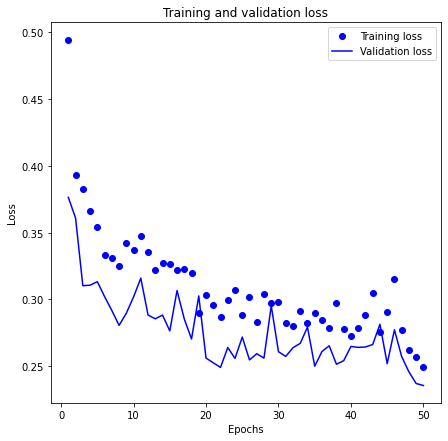

In [ ]:
history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

n = len(loss_values)
epochs = range(1, n+1)

plt.rcParams['figure.figsize'] = (7,7) # Make the figures a bit bigger
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

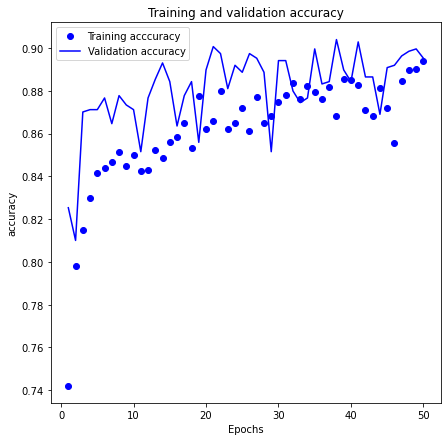

In [ ]:
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

n = len(acc_values)
epochs = range(1, n+1)

plt.rcParams['figure.figsize'] = (7,7) # Make the figures a bit bigger
plt.plot(epochs, acc_values, 'bo', label='Training acccuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()

plt.show()